In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
     

        self.conv1 = nn.Conv2d(1,16,3) #out put 26*26*16
        self.batchn1 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout(p=0.1);

        self.conv2 = nn.Conv2d(16,16,3) # 24*24*16
        self.batchn2 = nn.BatchNorm2d(16)
        self.drop2 = nn.Dropout(p=0.15);

        self.conv3 = nn.Conv2d(16,16,3) # output 22*22*16
        self.batchn3 = nn.BatchNorm2d(16)
        self.drop3 = nn.Dropout(p=0.15)

        self.pool1 = nn.MaxPool2d(2,2) #output 11*11*16
        
        self.onecross = nn.Conv2d(16,16,1) #output 11*11*16
        
        self.conv4 = nn.Conv2d(16,16,3) #output 9*9*16
        self.batchn4 = nn.BatchNorm2d(16)
        self.drop4 = nn.Dropout(p=0.15);

        self.conv5 = nn.Conv2d(16,16,3) #output 7*7*16
        self.batchn5 = nn.BatchNorm2d(16)
        self.drop5 = nn.Dropout(p=0.15);

        self.conv6 = nn.Conv2d(16,10,7) #output 1*1*10

    def forward(self, x):
        x = self.drop2(self.batchn2(F.relu(self.conv2(self.drop1(self.batchn1(F.relu(self.conv1(x))))))))
        x = self.drop4(self.batchn4(F.relu(self.conv4(self.onecross(self.pool1(self.drop3(self.batchn3(F.relu(self.conv3(x))))))))))
       
        x = self.conv6(self.drop5(self.batchn5(F.relu(self.conv5(x)))))
       
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

In [0]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
           Dropout-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,320
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           2,320
       BatchNorm2d-8           [-1, 16, 22, 22]              32
           Dropout-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             272
           Conv2d-12             [-1, 16, 9, 9]           2,320
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


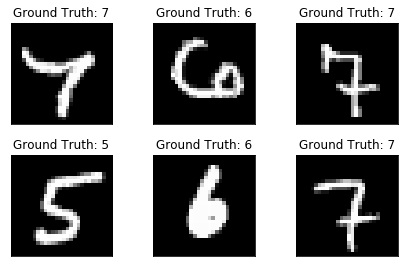

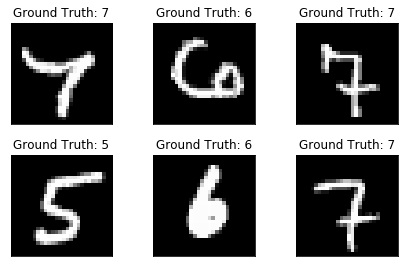

In [0]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

examples = enumerate(test_loader)
batch_idxx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


In [0]:
train_losses = []
train_counter = []
test_losses = []
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print ('--------EPOCH {}-----------'.format(epoch))
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

--------EPOCH 1-----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9857/10000 (99%)

--------EPOCH 2-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9876/10000 (99%)

--------EPOCH 3-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9886/10000 (99%)

--------EPOCH 4-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9915/10000 (99%)

--------EPOCH 5-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99%)

--------EPOCH 6-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99%)

--------EPOCH 7-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99%)

--------EPOCH 8-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99%)

--------EPOCH 9-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99%)

--------EPOCH 10-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9924/10000 (99%)

--------EPOCH 11-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9924/10000 (99%)

--------EPOCH 12-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9939/10000 (99%)

--------EPOCH 13-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99%)

--------EPOCH 14-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9935/10000 (99%)

--------EPOCH 15-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99%)

--------EPOCH 16-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9947/10000 (99%)

--------EPOCH 17-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9937/10000 (99%)

--------EPOCH 18-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9945/10000 (99%)

--------EPOCH 19-----------


loss=0.010955378413200378 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.82it/s]



Test set: Average loss: 0.0176, Accuracy: 9946/10000 (99%)

